# Data Curation Part 2 - Graph Extraction

This part of the data curation extract the access graphs (AGs) from the (residential-only) floor plans.

For processing the geometries, we use the `Shapely` (`shap`) library.
For processing the graphs, we use the `NetworkX` (`nx`) library.

## Algorithmic approach to extract the graphs

The AGs are extracted as follows (same as [paper](https://arxiv.org/abs/2407.10121); copy-pasted the text).

The AG is an attribute of a floor plan and explicitly models the connections (edges) between the areas (nodes).
We use an algorithmic approach to extract the graphs from the room shapes.
The procedure is as follows:

[$\bullet$] **Edge types.**
We define three types of edge connectivity:
`"passage"` when one can walk from one area to the other without a door in between;
`"door"` if two areas are connected by a door;
and `"front door"` if two areas are connected by a front door.

[$\bullet$] **Edge development.**
We iterate over all possible area pairs and create an edge between the two areas if 1) either the polygons that define the shapes of the areas are close enough ($\leq$ 0.04 m) -- in this case the edge type is `"passage"` -- or 2) there is a door for which the polygon that defines the door's shape is close enough to both area shapes ($\leq$ 0.05 m) -- in this case the edge type is either `"door"` or `"front door"` depending on the type of door.

[$\bullet$] **Node development.**
We include all necessary geometric and semantic information as node attributes.
`"centroid"`: is the center of the area.
`"geometry"`: is an array of the 2D coordinates representing the shape of the room as a polygon.
`"roomtype"`: is an integer representing the room category of the area.
`"zonetype"`: an integer representing the zoning category of the area.

[$\bullet$] **Room and zoning graph.**
We define the room graph as the graph including only `"roomtype"` node attributes, and the zoning graph as the graph including only `"zonetype"` node attributes.

## Loading the dataframe

We first load the cleaned and filtered dataframe (`data/MSD 5.664k (V1)`):

In [1]:
import pandas as pd
from geopandas import GeoDataFrame as gdf

# Import dataframe
DF = gdf(pd.read_csv('data/MSD 5.664k (V1).csv'))

# Check dataset size
print(f'Number of floors: {DF.floor_id.nunique()}')

Number of floors: 5664


## Graph extraction

We make use of the following functions that you can find under `graphs.py`:

- `get_geometries_from_id`: Gets all geometries for a certain floor identity (ID).
- `extract_access_graph`: Gets the access graph, in the format given in "Algorithmic approach to extract the graphs". Needs output from `get_geometries_from_id`.

We iterate over all floor IDs and accumulate their graphs.

Note that we show it only for gathering the room type access graphs: I.e., the nodes have a room type category associated to it.
The same can be done for zoning type access graphs: `column="zoning"` and `classes=ZONING_NAMES` in `get_geometries_from_id` and `extract_access_graph`, resp.

This might take some time!

**Important: Additional door geometries**
In this implementation (slightly different from the paper), we also add door geometries to the edges of the graph.
Only when the edge is `"door"` or `"entrance"`.
In the case of `"passage"`, there is no edge attribute.

In [2]:
from tqdm.auto import tqdm
from constants import ROOM_NAMES  #, ZONING_NAMES  # if you want to get the zoning type access graphs
from graphs import get_geometries_from_id, extract_access_graph

# Initializes empty list to story the graphs
graphs = []

# Gets unique floor ids
floor_ids = list(set(DF.floor_id))

# Iterates over floor IDs
for id in tqdm(floor_ids):
    geoms, types = get_geometries_from_id(DF, id, column="roomtype")
    G = extract_access_graph(geoms, types, ROOM_NAMES, id)
    graphs.append(G)

  0%|          | 0/5664 [00:00<?, ?it/s]

## Removing 'disconnected' floor plans

Some access graphs are disconnected.
This could come from different sources; some which are fine and some which are not so fine.
For instance, not all individual apartments are connected to each other in a building -- in this case, the disconnectedness is fine.
In other cases, some nodes in the graph are disconnected from the rest, which means that some rooms are unaccessible from any other room.
We remove floor plans that contain such nodes.

## Saving the graphs

We save the graphs as `"data/MSD Graphs <size of dataset> (V1).pickle"` under the folder `data`.

In [3]:
from utils import save_pickle

save_pickle(graphs, f"data/MSD Graphs {len(graphs)/1000:.3f}k (V1).pickle")

## Plotting the graphs

For plotting the graphs we use the `plot_floor` function that you can find back under `plot.py`.

We plot 16 randomly picked floor plans and plot them on a 4 x 4 grid.

Edges are black for interior doors and passages; edges are red (and wider) for front door / entrances.

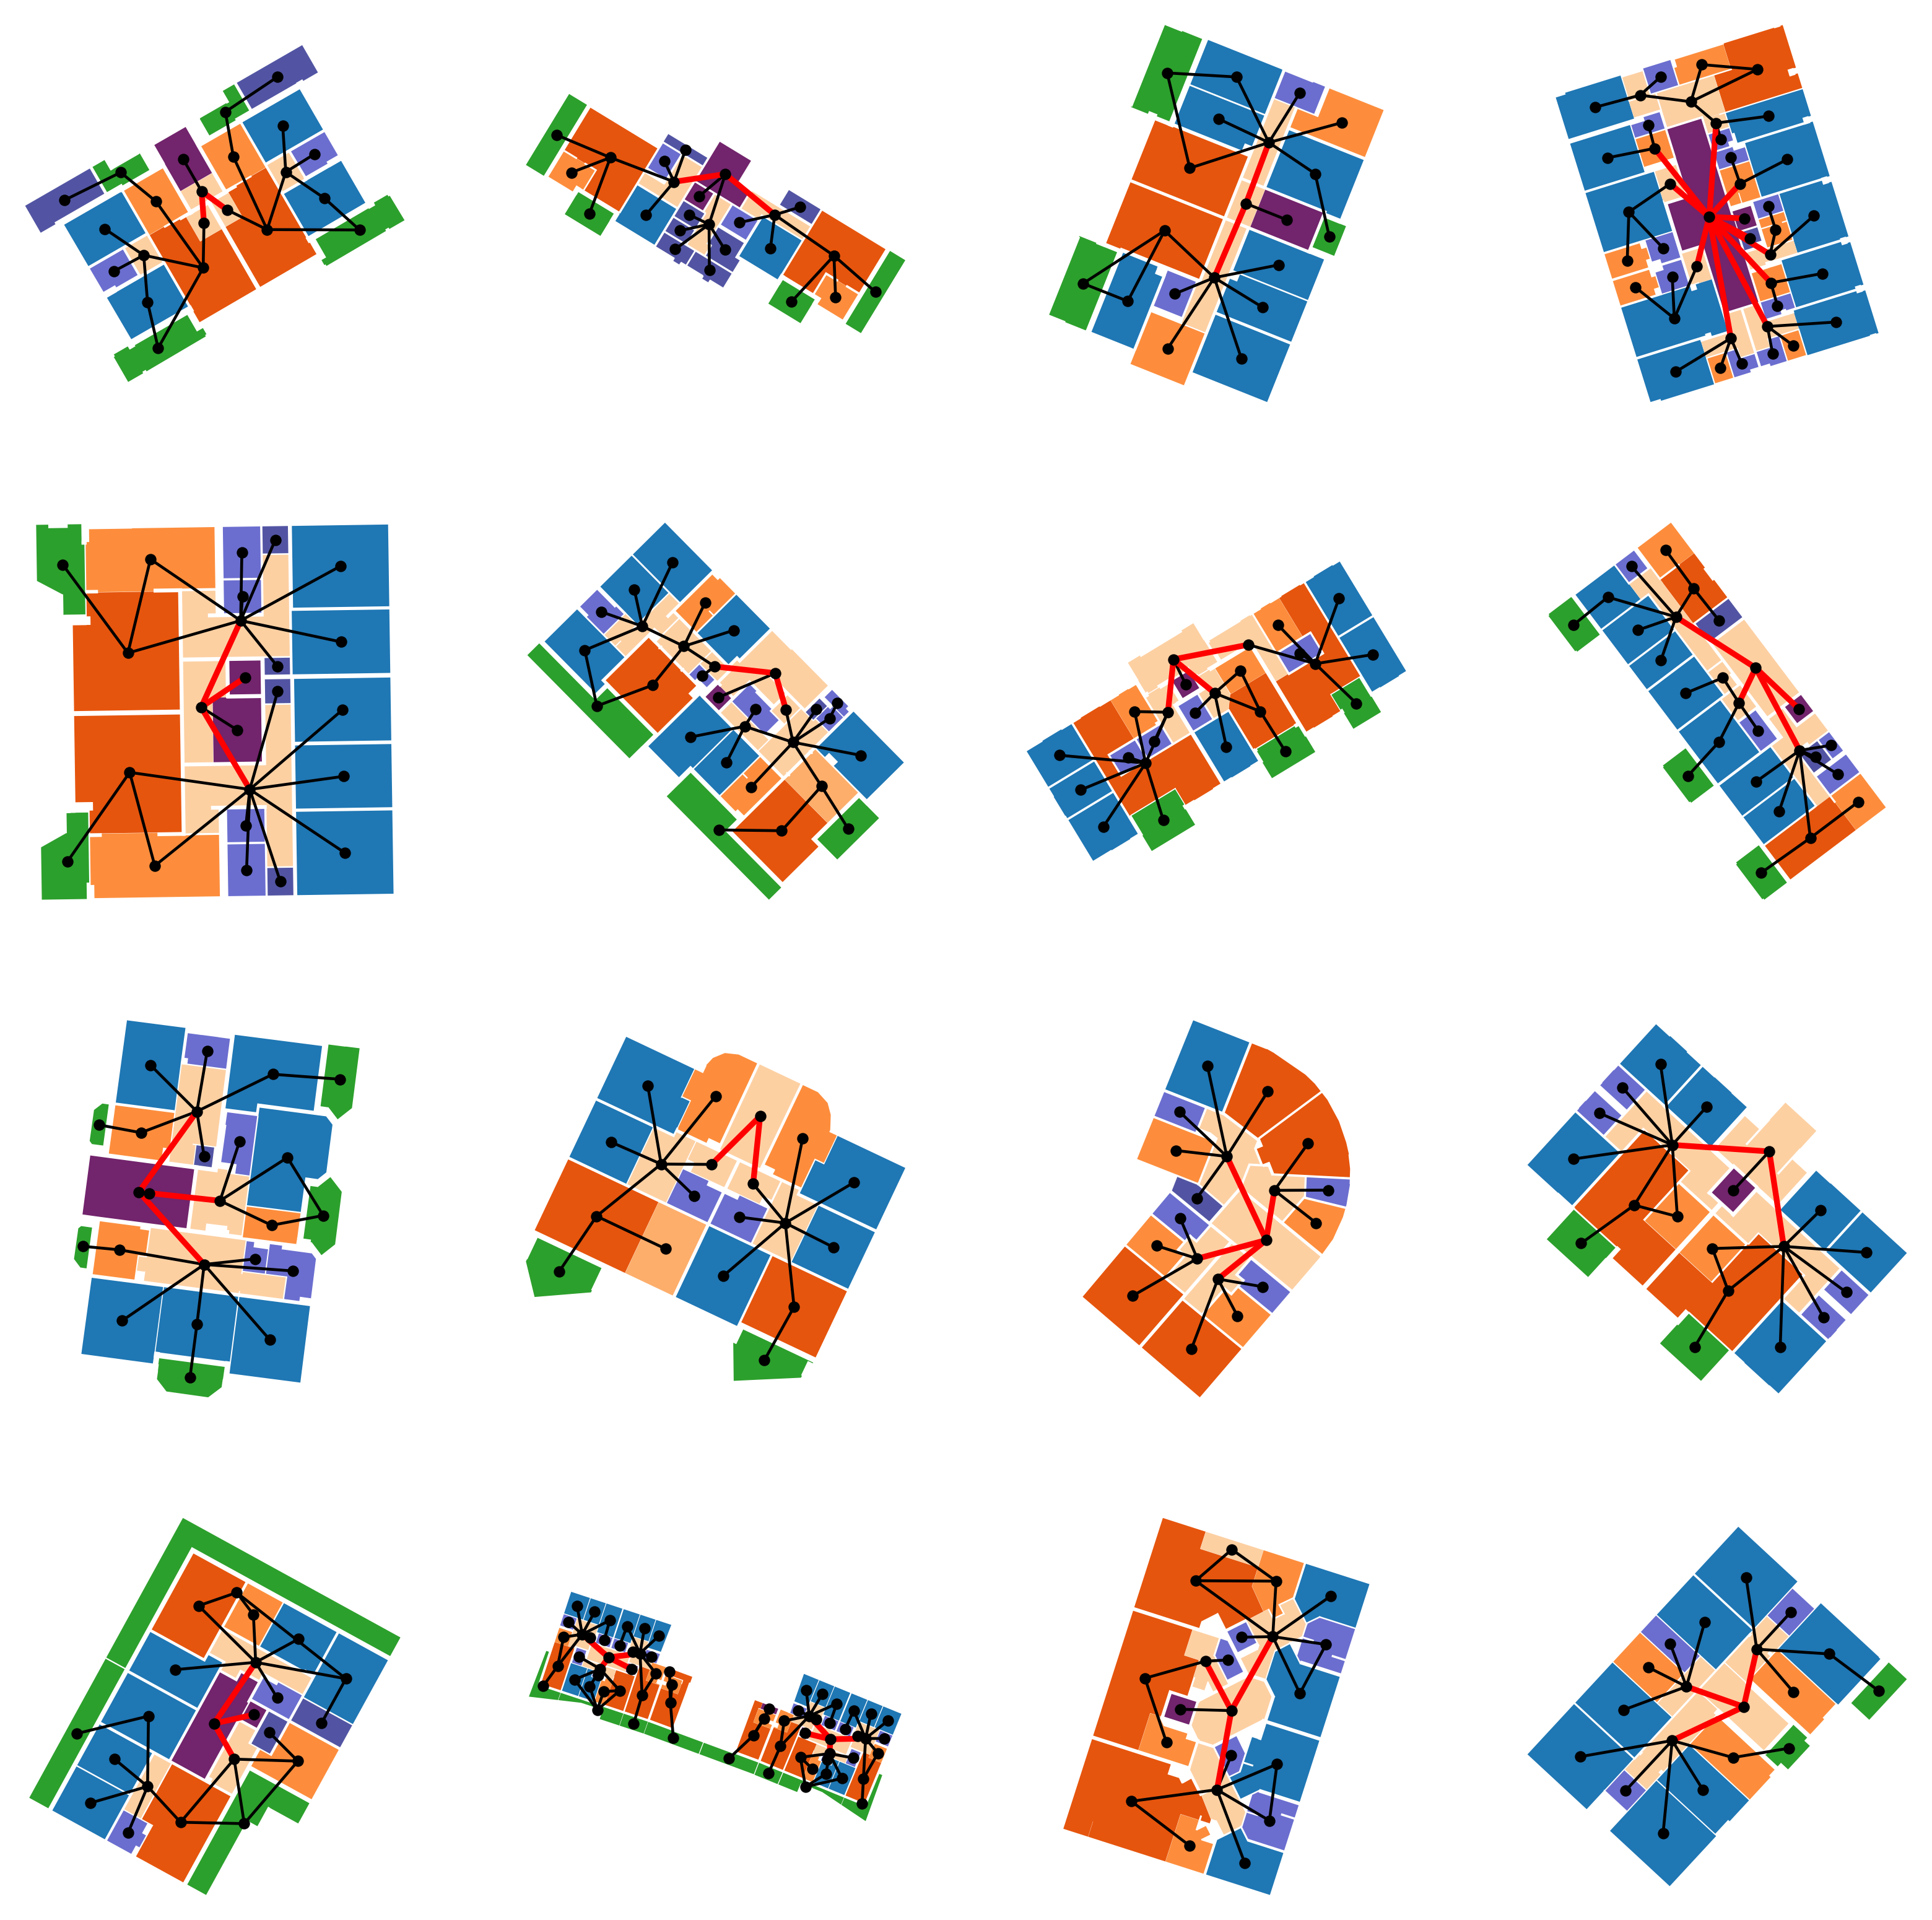

In [8]:
import random
import matplotlib.pyplot as plt

from plot import plot_floor

# Pick random indices
N = 16  # Number of floor plans to visualize
random.seed(12)  # Seed for reproducibility

# Set up figure
fs = 10
fig, axs = plt.subplots(4, 4,figsize=(fs*4,fs*4))
axs = axs.flatten()
fig.set_facecolor('white')
node_size = fs*15
edge_size = fs/3

# Iterate over random subsample of graphs
for G, ax in zip(random.sample(graphs, k=N), axs):

    # Set axis
    _ = [ax.axis('off'), ax.axes.set_aspect('equal')]

    # Plot graph
    plot_floor(G, ax, node_size=node_size, edge_size=edge_size)